In [454]:
import numpy as np
import pandas as pd
from numba import njit
from scipy.stats import norm, halfnorm, uniform
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import bayesflow as bf
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import r2_score

import sys
sys.path.append("../src/")
from model import generative_model, sample_rlwm
from configurator import configure_input
from helpers import truncnorm_better
from context import generate_context

In [455]:
%load_ext autoreload
%autoreload 2
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [456]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# print(tf.config.list_physical_devices('GPU'))

## Constants

In [458]:
TRAIN_NETWORK = True

In [459]:
# parameters
THETA_NAMES = ("Learning rate", "Memory contribution")
THETA_LABELS= (r"$\alpha$", r"$p$")
ETA_NAMES = ("Transition scale", "Transition scale")
ETA_LABELS= (r"$\sigma_{\alpha}$", r"$\sigma_{p}$")
KAPPA_NAMES = ("Memory decay", "Memory capacity")
KAPPA_LABELS= (r"$\phi$", r"$c$")

THETA_PRIOR_MEAN = np.array([0.5, 0.5])
THETA_PRIOR_STD = np.array([0.3, 0.3])
ETA_PRIOR_MEAN = np.round(halfnorm(0, 0.05).mean(), decimals=2)
ETA_PRIOR_STD = np.round(halfnorm(0, 0.05).std(), decimals=2)
KAPPA_PRIOR_MEAN = np.array([0.5, 4.7])
KAPPA_PRIOR_STD = np.array([0.3, 1])

# plotting
FONT_SIZE_1 = 22
FONT_SIZE_2 = 18
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

# analysis
NUM_VALIDATION_SIM = 400
NUM_SAMPLES = 500
NUM_RESIM = 100

## Data Preparation

In [460]:
data = pd.read_csv("../data/data_prepared.csv")
NUM_SUBJECTS = len(np.unique(data.id))
emp_data = np.zeros((NUM_SUBJECTS, 780, 15))
for i, sub in enumerate(np.unique(data.id)):
    person_data = data.loc[data.id == sub]
    stim_one_hot = to_categorical(person_data.stim)
    resp_one_hot = to_categorical(person_data.resp)
    reward = person_data.reward.to_numpy()[:, None]
    correct_resp_one_hot = to_categorical(person_data.correct_resp)
    block = (person_data.block / 13).to_numpy()[:, None]
    set_size = ((person_data.set_size / 3) - 1).to_numpy()[:, None]
    emp_data[i] = np.c_[
        resp_one_hot, reward, stim_one_hot,
        correct_resp_one_hot, block, set_size
    ].astype(np.float32)

## Parameters

$\alpha \rightarrow$ Learning rate [0, 1] dynamic

$\tau \rightarrow$ Inverse temperature [0, ] fix it at 10

$\phi \rightarrow$ Memory decay [0, 1] static

$w \rightarrow$ Memory contribution = $p*min(1, \frac{C}{n_S})$

$p \rightarrow$ Initial memory weighting [0, 1] dynamic

$C \rightarrow$ Memory capacity [0, ] is usually 5-9 static

$n_S \rightarrow$ Set size in current block

$\gamma \rightarrow$ Perseveration [0, 1] we don't need this at all because alpha is already dynamic

## Context

Column 1: Stimulus [0, 5]

Column 2: Correct response [0, 2]

Column 3: Block id [1, 14]

Columns 4: Set size [3, 6]

## Generative Model

In [473]:
%%time
forward_dict = generative_model(32)
_ = configure_input(forward_dict)
local_params = _['local_parameters'] * THETA_PRIOR_STD + THETA_PRIOR_MEAN

CPU times: user 57.4 ms, sys: 852 µs, total: 58.2 ms
Wall time: 57.9 ms


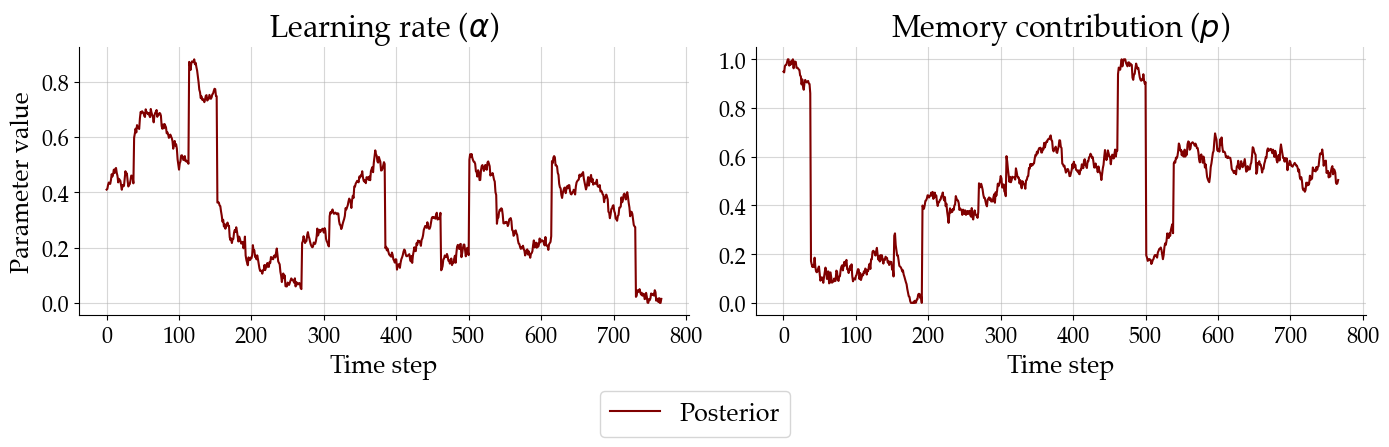

In [498]:
which = 23
time = np.arange(local_params.shape[1])
fig, axarr = plt.subplots(1, 2, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        local_params[which, :, i],
        color='maroon', label="Posterior"
    )
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

## Neural Approximator

In [499]:
approximator_settings = {
    "lstm1_hidden_units": 512,
    "lstm2_hidden_units": 256,
    "lstm3_hidden_units": 128,
    "trainer": {
        "max_to_keep": 1,
        "default_lr": 5e-4,
        "memory": False,
    }
}

In [500]:
summary_network = bf.networks.HierarchicalNetwork(
    [
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm1_hidden_units"], return_sequences=True)),
                Bidirectional(LSTM(approximator_settings["lstm2_hidden_units"], return_sequences=True)),
            ]
        ),
        Sequential(
            [
                Bidirectional(LSTM(approximator_settings["lstm3_hidden_units"]))
            ]
        )
    ]
)

In [501]:
local_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=2,
        num_coupling_layers=8,
        coupling_settings={
            "dense_args": dict(kernel_regularizer=None),
            "dropout": False,
            "coupling_design": 'interleaved'
        }
    )
)
global_network = bf.amortizers.AmortizedPosterior(
    bf.networks.InvertibleNetwork(
        num_params=2+2,
        num_coupling_layers=6,
        coupling_settings={
            "dense_args": dict(kernel_regularizer=None),
            "dropout": False,
            "coupling_design": 'interleaved'
        }
    )
)


In [502]:
amortizer = bf.amortizers.TwoLevelAmortizedPosterior(
    local_amortizer=local_network,
    global_amortizer=global_network,
    summary_net=summary_network
)
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=generative_model,
    configurator=configure_input,
    **approximator_settings.get("trainer"),
    checkpoint_path="../checkpoints/ns_rlwm_2"
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


## Training

In [11]:
%%time
if TRAIN_NETWORK:
    history = trainer.train_online(
        epochs=200, 
        iterations_per_epoch=1000, 
        batch_size=16
    )
else:
    history = trainer.loss_history.get_plottable()

CPU times: user 43.7 ms, sys: 1.24 ms, total: 44.9 ms
Wall time: 44.7 ms


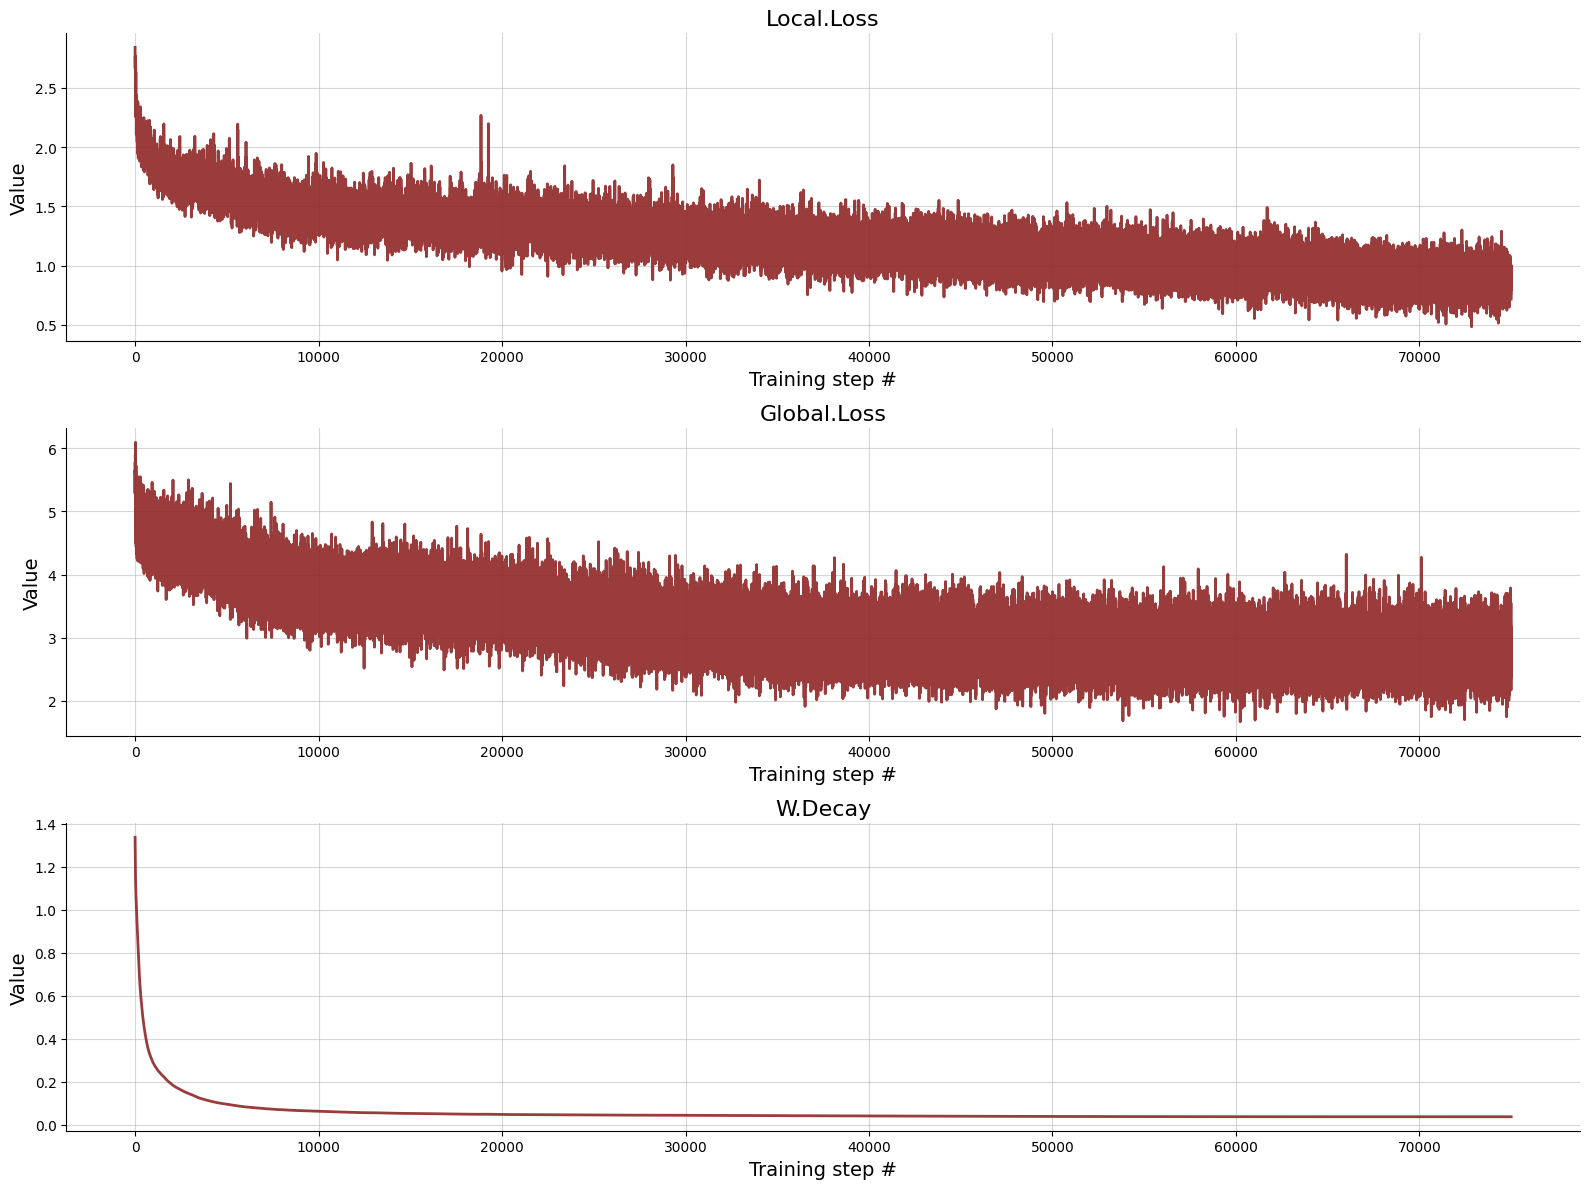

In [12]:
f = bf.diagnostics.plot_losses(history)

## Validation

In [103]:
NUM_VALIDATION_SIM = 400
NUM_SAMPLES = 500

In [104]:
validation_sims = generative_model(NUM_VALIDATION_SIM)
val_data_conf = configure_input(validation_sims)

In [105]:
true_theta = validation_sims['local_parameters']
true_eta = validation_sims['global_parameters']
true_kappa = validation_sims['shared_parameters']

In [106]:
NUM_STEPS = validation_sims['sim_data'].shape[1]
print(
    f"Estimation will be performed on data sets with {NUM_STEPS} simulated trials."
)

Estimation will be performed on data sets with 770 simulated trials.


In [107]:
post_theta = np.zeros((NUM_VALIDATION_SIM, NUM_STEPS, NUM_SAMPLES, 2))
post_eta = np.zeros((NUM_VALIDATION_SIM, NUM_SAMPLES, 2))
post_kappa = np.zeros((NUM_VALIDATION_SIM, NUM_SAMPLES, 2))
for i in tqdm(range(NUM_VALIDATION_SIM)):
    tmp_data = {
        'summary_conditions': val_data_conf['summary_conditions'][i][None, :, :],
        'direct_conditions': val_data_conf['direct_conditions'][i][None, :]
    }
    samples = amortizer.sample(tmp_data, NUM_SAMPLES)
    post_theta[i] = samples['local_samples']
    post_eta[i] = samples['global_samples'][:, :2]
    post_kappa[i] = samples['global_samples'][:, 2:]

100%|██████████| 400/400 [1:09:35<00:00, 10.44s/it]


### Local Parameters

In [146]:
post_theta_trans = post_theta * THETA_PRIOR_STD + THETA_PRIOR_MEAN
post_theta_means = post_theta_trans.mean(axis=2)
post_theta_stds = post_theta_trans.std(axis=2)
post_theta_median = np.median(post_theta_trans, axis=2)

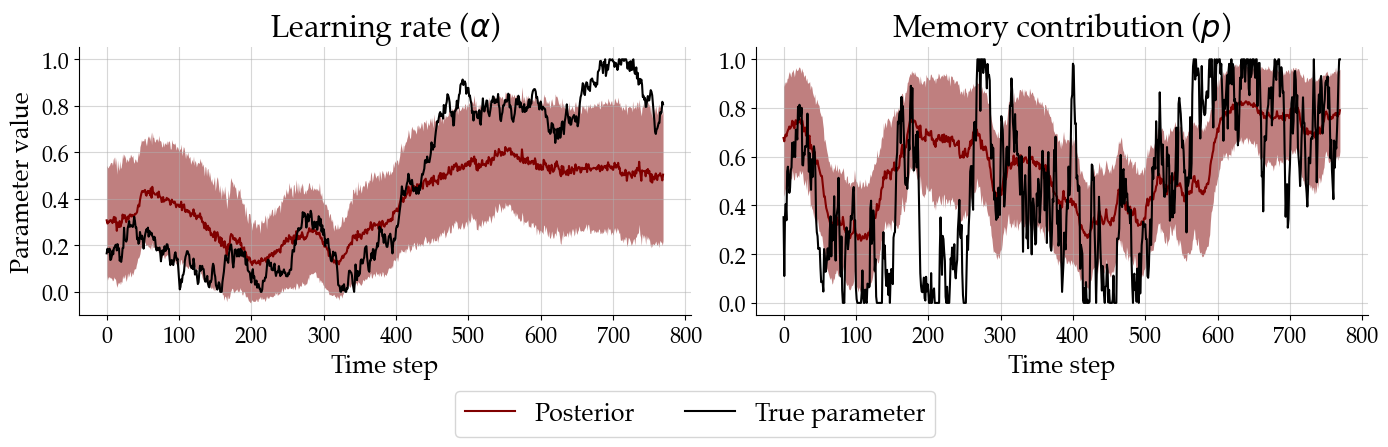

In [450]:
which = 11
time = np.arange(post_theta_means[which].shape[0])
fig, axarr = plt.subplots(1, 2, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    ax.plot(
        time,
        post_theta_means[which, :, i],
        color='maroon', label="Posterior"
    )
    ax.plot(
        time,
        true_theta[which, :, i],
        color='black', label="True parameter"
    )
    ax.fill_between(
        time,
        post_theta_means[which, :, i] - post_theta_stds[which, :, i],
        post_theta_means[which, :, i] + post_theta_stds[which, :, i],
        color='maroon', alpha=0.5, linewidth=0.0
    )
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)

sns.despine()
fig.tight_layout()

In [153]:
r2_scores = np.zeros((NUM_STEPS, 2))
for t in range(NUM_STEPS):
    for p in range(2):
        r2_scores[t, p] = r2_score(true_theta[:, t, p], post_theta_median[:, t, p])

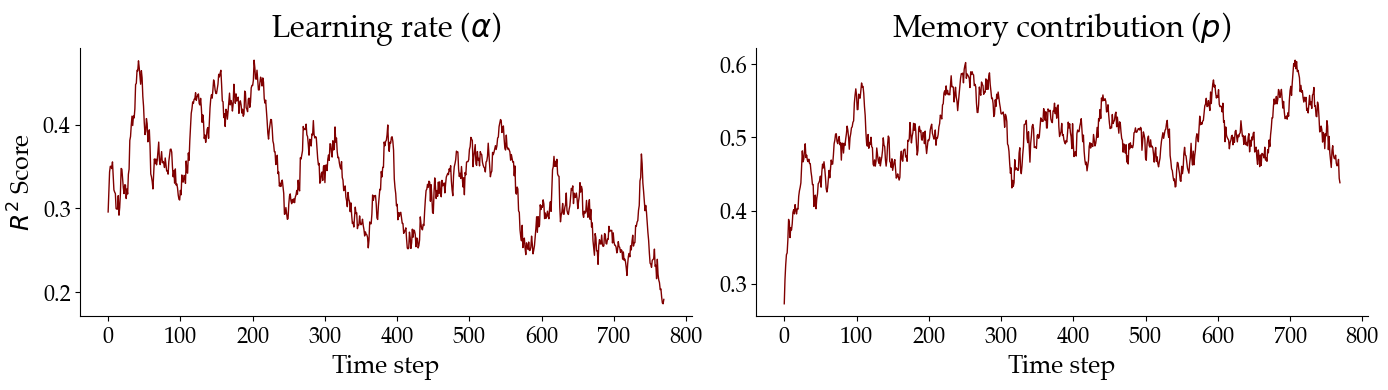

In [161]:
fig, axarr = plt.subplots(1, 2, figsize=(14, 4))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(NUM_STEPS), r2_scores[: , i], linewidth=1, color='maroon')
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel(r"$R^2$ Score", fontsize=FONT_SIZE_2)
        fig.subplots_adjust(hspace=0.5)
        # fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)
    
sns.despine()
fig.tight_layout()

### Global Parameters

In [122]:
post_eta_trans = post_eta * ETA_PRIOR_STD + ETA_PRIOR_MEAN

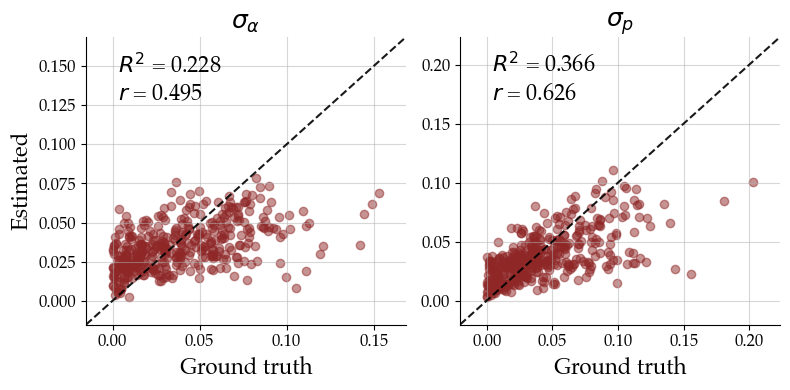

In [136]:
f = bf.diagnostics.plot_recovery(
    post_eta_trans, true_eta,
    param_names=ETA_LABELS,
    uncertainty_agg=None
)

### Shared Parameters

In [124]:
post_kappa_trans = post_kappa * KAPPA_PRIOR_STD + KAPPA_PRIOR_MEAN

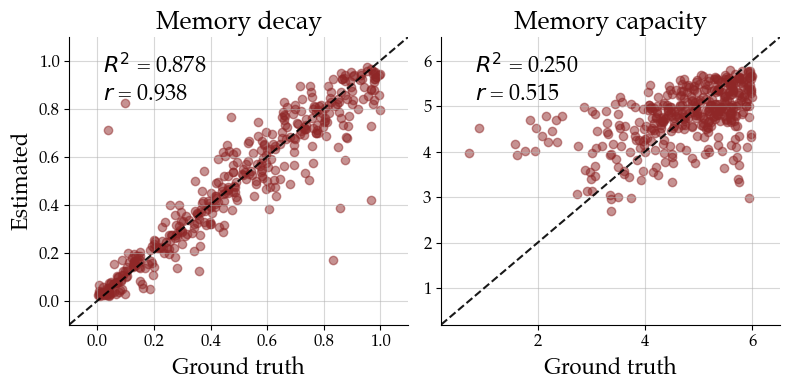

In [134]:
f = bf.diagnostics.plot_recovery(
    post_kappa_trans, true_kappa,
    param_names=KAPPA_NAMES,
    uncertainty_agg=None
)

## Data Fitting

In [321]:
theta_post_samples = np.zeros((NUM_SUBJECTS, 780, NUM_SAMPLES, 2))
eta_post_samples = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 2))
kappa_post_samples = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 2))
for i in tqdm(range(NUM_SUBJECTS)):
    tmp_data = {'summary_conditions': emp_data[i][None, :, :]}
    post_samples = amortizer.sample(tmp_data, NUM_SAMPLES)
    theta_post_samples[i] = post_samples['local_samples']
    eta_post_samples[i] = post_samples['global_samples'][:, :2]
    kappa_post_samples[i] = post_samples['global_samples'][:, 2:]

100%|██████████| 91/91 [16:30<00:00, 10.89s/it]


In [323]:
theta_post_samples_trans = theta_post_samples * THETA_PRIOR_STD + THETA_PRIOR_MEAN
theta_post_means = theta_post_samples_trans.mean(axis=2)
theta_post_stds = theta_post_samples_trans.std(axis=2)
kappa_post_samples_trans = kappa_post_samples * KAPPA_PRIOR_STD + KAPPA_PRIOR_MEAN
kappa_post_means = kappa_post_samples_trans.mean(axis=1)
kappa_post_stds = kappa_post_samples_trans.std(axis=1)

## Parameter Estimates

### Local Parameters

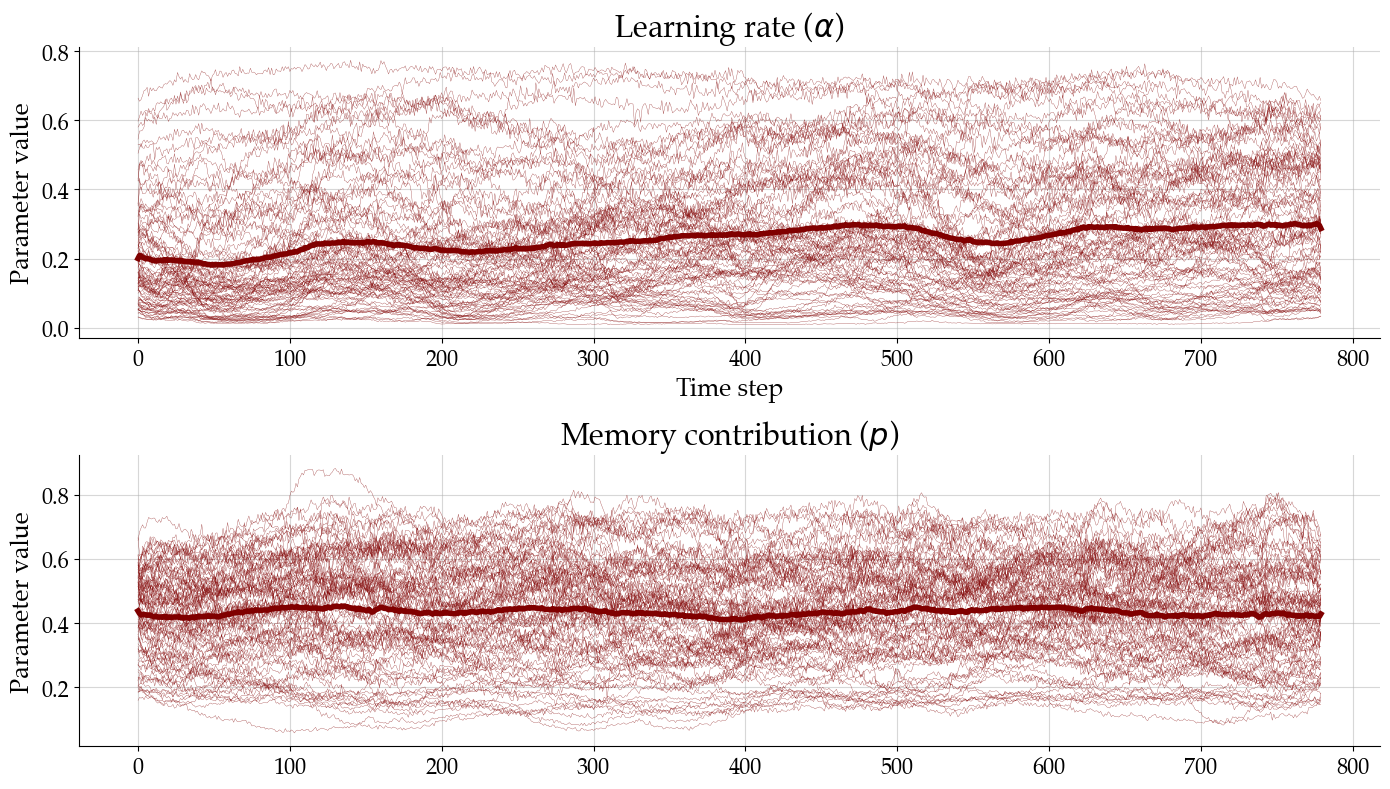

In [448]:
time = np.arange(780)
fig, axarr = plt.subplots(2, 1, figsize=(14, 8))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    for j in range(NUM_SUBJECTS):
        ax.plot(
            time,
            theta_post_means[j, :, i],
            color='maroon', lw=0.25, alpha=0.75
        )
    ax.plot(
        time,
        theta_post_means.mean(axis=0)[:, i],
        color='maroon', lw=4
    )
    # ax.fill_between(
    #     time,
    #     post_theta_means[which, :, i] - post_theta_stds[which, :, i],
    #     post_theta_means[which, :, i] + post_theta_stds[which, :, i],
    #     color='maroon', alpha=0.5, linewidth=0.0
    # )
    ax.set_title(f'{THETA_NAMES[i]} ({THETA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_xlabel("Time step", fontsize=FONT_SIZE_2)
    ax.set_ylabel("Parameter value", fontsize=FONT_SIZE_2)
        # fig.subplots_adjust(hspace=0.5)
        # fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.05), loc="center", ncol=2)
    

sns.despine()
fig.tight_layout()

### Shared Parameters

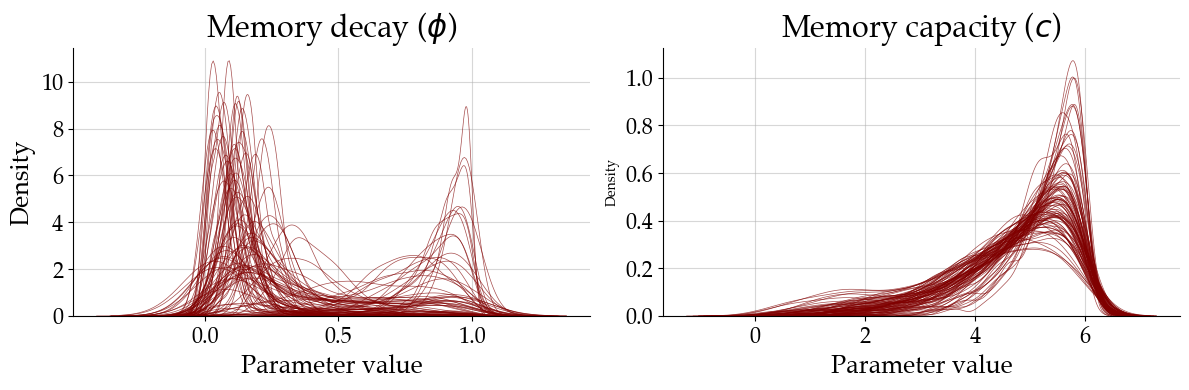

In [325]:
time = np.arange(780)
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
for i, ax in enumerate(axarr.flat):
    ax.grid(alpha=0.5)
    for j in range(NUM_SUBJECTS):
        sns.kdeplot(
            kappa_post_samples_trans[j, :, i],
            ax=ax, color="maroon", 
            linewidth=0.5, alpha=0.7
        )
    ax.set_title(f'{KAPPA_NAMES[i]} ({KAPPA_LABELS[i]})', fontsize=FONT_SIZE_1)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    if i == 0:
        ax.set_ylabel("Density", fontsize=FONT_SIZE_2)
    ax.set_xlabel("Parameter value", fontsize=FONT_SIZE_2)
sns.despine()
fig.tight_layout()

## Posterior Re-simulation

In [379]:
resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIM, 780, 2))

In [380]:
for i, sub in tqdm(enumerate(data.id.unique())):
    person_data = data.loc[data.id == sub]
    context = person_data[["stim", "correct_resp", "block", "set_size"]].to_numpy()
    idx = RNG.choice(
        np.arange(NUM_SAMPLES), NUM_RESIM, replace=False
    )
    tmp_theta_samples = theta_post_samples_trans[i, :, idx, :]
    tmp_kappa_samples = kappa_post_samples_trans[i, idx, :]
    for j in range(NUM_RESIM):
        resim_data[i, j] = sample_rlwm(
            tmp_theta_samples[j],
            tmp_kappa_samples[j],
            context
        )

91it [00:04, 18.56it/s]


In [373]:
pred_accuracy = np.zeros((NUM_RESIM, 26))
for i in range(NUM_RESIM):
    new_data = {
        'set_size': data.set_size,
        'iteration': data.iteration,
        'correct': resim_data[:, i, :, 1].flatten()
    }
    new_data = pd.DataFrame(new_data)
    pred_grouped_mean = new_data.groupby(['set_size', 'iteration'])['correct'].mean().reset_index()
    pred_accuracy[i] = pred_grouped_mean.correct.to_numpy()[:26]

In [374]:
pred_accuracy_mean = pred_accuracy.mean(axis=0)
pred_accuracy_std = pred_accuracy.std(axis=0)
pred_accuracy_mean.shape

(26,)

In [375]:
grouped_mean = data.groupby(['set_size', 'iteration'])['correct'].mean().reset_index()

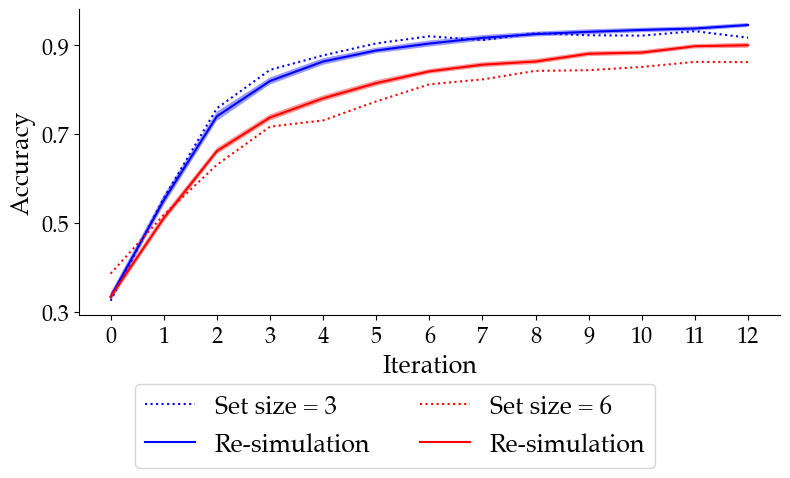

In [376]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(
    np.arange(13), grouped_mean.loc[grouped_mean.set_size == 3].correct,
    linewidth=1.5, linestyle="dotted", color='blue', label="Set size = 3"
)
ax.plot(
    np.arange(13), pred_accuracy_mean[:13],
    linewidth=1.5, color='blue', label="Re-simulation"
)
ax.fill_between(
    np.arange(13),
    pred_accuracy_mean[:13] - pred_accuracy_std[:13],
    pred_accuracy_mean[:13] + pred_accuracy_std[:13],
    color='blue', edgecolor=None, alpha=0.4
)
ax.plot(
    np.arange(13), grouped_mean.loc[(grouped_mean.set_size == 6) & (grouped_mean.iteration < 14)].correct,
    linewidth=1.5, linestyle="dotted", color='red', label="Set size = 6"
)
ax.plot(
    np.arange(13), pred_accuracy_mean[13:],
    linewidth=1.5, color='red', label="Re-simulation"
)
ax.fill_between(
    np.arange(13),
    pred_accuracy_mean[13:] - pred_accuracy_std[13:],
    pred_accuracy_mean[13:] + pred_accuracy_std[13:],
    color='red', edgecolor=None, alpha=0.4
)

ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
fig.subplots_adjust(hspace=0.75)
fig.legend(fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.08), loc="center", ncol=2)
ax.set_xlabel("Iteration", fontsize=FONT_SIZE_2)
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE_2)
ax.set_xticks(np.arange(13))
ax.set_yticks(np.arange(0.3, 1, 0.2))
    
sns.despine()
fig.tight_layout()